# Dropconnect Transformation 

This notebook is meant as a, practical introduction to the **Dropconnect transformation** in `probly`.
The goal is not to be mathematically perfect, but to give you an intuition.

We will slowly build up from the very basic idea of *normal* Dropout to the slightly more advanced idea of
a **Dropout transformation that makes a model uncertainty‑aware**. After that, we look at a small PyTorch
example and inspect how the transformation changes the model.

---
## Part A: Introduction to Dropconnect and the Dropconnect Transformation
---


## 1. Concept: What is Dropconnect (normal) vs Dropconnect Transformation?

To understand the DropConnect transformation, it's helpful to first compare it to the more common Dropout.
### 1.1 Normal Dropout (Recap)

Dropout is a regularization technique that works on activations. During training, it randomly sets the outputs of some neurons to zero.
 This prevents the network from relying too heavily on any single neuron.
### 1.2 Normal DropConnect
DropConnect is a similar regularization technique, but it works on weights. Instead of setting a neuron's entire output to zero, 
DropConnect randomly sets a fraction p of the individual weights within a layer to zero for each training step. 
You can imagine this as temporarily deleting connections between neurons.

This is considered a more generalized form of Dropout. Like Dropout, its main purpose during normal training is to prevent overfitting
and improve the model's robustness. At inference time `(model.eval())`, this randomness is disabled, and the model becomes deterministic.

### 1.3 DropConnect Transformation (probly)

The DropConnect transformation in `probly`takes this idea and uses it to make a model **uncertainty‑aware** at prediction time.

The transformation does the following:
 
- It walks through your PyTorch model and finds the relevant linear layers (e.g., `nn.Linear`).
- It programmatically replaces each `nn.Linear`layer with a custom `DropConnectLinear` layer.

- Crucially, this custom layer keeps the DropConnect mechanism **active during inference**.

If we now feed the same input through the transformed model multiple times, we get a cloud of slightly different predictions. The variation in this cloud is a direct measure of the model's uncertainty.

### 1.4 A Short side‑by‑side comparison

| Aspect                       | DropConnect Transformation (probly)                    | Dropout Transformation (probly)                          |
|------------------------------|--------------------------------------------------------|----------------------------------------------------------|
| What is dropped?             | Individual weights inside a layer                      | Entire activations (neuron outputs)                      |
| How it modifies the model    | Replaces `nn.Linear` with `DropConnectLinear`          | Inserts `nn.Dropout layers` before `nn.Linear`           |
| When it's active             | Intentionally in `model.eval()`                        | Intentionally in `model.eval()`                          |
| Main purpose                 | Make predictions uncertainty‑aware                     | Make predictions uncertainty‑aware           |
|Output behaviour in eval      | Stochastic (same input → slightly different outputs)   | Stochastic (same input → slightly different outputs)     |

The rest of this notebook now assumes this picture: **“normal” Dropout is a training regulariser, the
Dropout transformation turns the same mechanism into a tool for estimating uncertainty.**





## 2. Quickstart (PyTorch)

Below: build a small MLP, apply `dropconnect(model, p)`, and inspect the modified architecture.

In [4]:
import torch
from torch import nn

from probly.transformation import dropconnect


def build_mlp(in_dim: int = 10, hidden: int = 32, out_dim: int = 1) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(in_dim, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, out_dim),
    )


p = 0.2  # dropconnect probability

model = build_mlp()
print("Original model:\n", model)

model_dc = dropconnect(model, p)
print(f"\nWith DropConnect transformation (p={p:.2f}):\n", model_dc)

Original model:
 Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

With DropConnect transformation (p=0.20):
 Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): DropConnectLinear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): DropConnectLinear(in_features=32, out_features=1, bias=True)
)


### Notes on the structure

Notice that each `Linear` layer has been replaced by a `DropConnectLinear` layer.

The overall architecture (`Sequential`, `ReLU`) remains the same, but the core linear modules are now uncertainty-aware.

## 3. Uncertainty via DropConnect

To obtain predictive uncertainty, we run multiple stochastic forward passes (with DropConnect active) and compute the mean and variance of the predictions. The process is identical to MC-Dropout.

In [5]:
# Toy regression data
torch.manual_seed(0)
n = 128
X = torch.randn(n, 10)
true_w = torch.randn(10, 1)
y = X @ true_w + 0.1 * torch.randn(n, 1)

# Build and transform the model
model = build_mlp(in_dim=10, hidden=64, out_dim=1)
model_dc = dropconnect(model, p=0.2)

# Simple training loop
opt = torch.optim.Adam(model_dc.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

model_dc.train() # Activate DropConnect for training
for _step in range(200):
    opt.zero_grad()
    pred = model_dc(X)
    loss = loss_fn(pred, y)
    loss.backward()
    opt.step()


# MC prediction function
@torch.no_grad()
def mc_predict(
    model_with_dropconnect: nn.Module,
    inputs: torch.Tensor,
    n_samples: int = 50,
) -> tuple[torch.Tensor, torch.Tensor]:
    # Activate training mode to enable the stochasticity of DropConnect
    model_with_dropconnect.train()
    preds = []
    for _ in range(n_samples):
        preds.append(model_with_dropconnect(inputs).detach())
    stacked = torch.stack(preds, dim=0)  # [n_samples, N, out_dim]
    mean = stacked.mean(dim=0)
    var = stacked.var(dim=0, unbiased=False)
    return mean, var


mean_pred, var_pred = mc_predict(model_dc, X[:5], n_samples=100)
print("Predictive mean (first 5):\n", mean_pred.squeeze())
print("\nPredictive variance (first 5):\n", var_pred.squeeze())

Predictive mean (first 5):
 tensor([-1.2788,  3.1010,  1.6500, -1.6051, -0.8758])

Predictive variance (first 5):
 tensor([0.0370, 0.1376, 0.0453, 0.0445, 0.0266])


## 4. Good practices

- Tune the DropConnect probability `p` (e.g., 0.1–0.5) as a hyperparameter.
- Use a reasonable number of Monte Carlo samples (e.g., 20–200). More samples give smoother estimates but are computationally slower.
- Since DropConnect replaces layers, it's a good idea to confirm your model's performance doesn't degrade significantly after transformation.



## 5. Common errors
- `ValueError: p must be between 0 and 1` — ensure `0 ≤ p ≤ 1`.
- Seeing no `DropConnectLinear` layers? Confirm your model contains `nn.Linear` modules that probly can detect and replace.

## 6. Next steps

- Explore how DropConnect behaves with different architectures.
- Compare the uncertainty estimates from DropConnect with those from the Dropout transformation on the same task.

## 7. Part A Summary
In Part A, we distinguished between Dropout and DropConnect and explored how the DropConnect Transformation works in `probly`. 
While standard DropConnect is a regularization technique that drops individual weights during training, the `probly` transformation adapts this mechanism for uncertainty estimation.
 It achieves this by replacing standard `nn.Linear ` layers with custom `DropConnectLinear` layers that remain stochastic even during inference. 
 This allows us to generate a distribution of predictions for a single input, where the variance serves as a measure of model uncertainty. 


---

## Part B — Applied MC-Dropconnect
--- 

In **Part A** , we learned what the `DropConnect`transformation in `probly` does by replacing layers to make a model stochastic.
In this **Part B** , we will apply that transformation, run several stochastic predictions, and visualize the resulting uncertainty.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from probly.transformation import dropconnect

torch.manual_seed(42)


class TinyNet(nn.Module):
    """A tiny neural network for demonstration, built with standard layers."""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 8)
        self.out = nn.Linear(8, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


# dummy input
x = torch.randn(1, 16)
base_model = TinyNet().eval()

## 2. Apply the DropConnect transformation

We now transform the base model with `dropconnect()`. This will replace its `nn.Linear` layers with `DropConnectLinear`layers that stay active during inference.

In [8]:
mc_model_dc = dropconnect(base_model, p=0.25)
mc_model_dc.eval()  # Activate stochasticity for MC passes


TinyNet(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): DropConnectLinear(in_features=32, out_features=8, bias=True)
  (out): DropConnectLinear(in_features=8, out_features=3, bias=True)
)

## 3. Monte-Carlo inference: repeated forward passes
We feed the same input through the model multiple times and collect the stochastic outputs.

In [9]:
num_passes = 100
logits_list = []

with torch.no_grad():
    for _ in range(num_passes):
        logits_list.append(mc_model_dc(x))

logits = torch.cat(logits_list, dim=0)  # [num_passes, 3]
probs = torch.softmax(logits, dim=-1)  # convert to probabilities

## 4. Quantify uncertainty

Compute the mean and standard deviation across all passes — these capture the central tendency and spread (uncertainty).

In [10]:
from probly.quantification import classification as q

# Reshape for probly's quantification functions: [n_instances, n_samples, n_classes]
probs_reshaped = probs.unsqueeze(0)

mean_probs = probs.mean(dim=0)
std_probs = probs.std(dim=0, unbiased=False)

pred_class = mean_probs.argmax().item()
predictive_entropy = q.total_entropy(probs_reshaped).item()

print("Mean probabilities:", mean_probs)
print("Std probabilities:", std_probs)
print("Predicted class:", pred_class)
print(f"Predictive entropy: {predictive_entropy:.4f}")

Mean probabilities: tensor([0.3199, 0.3917, 0.2884])
Std probabilities: tensor([0., 0., 0.])
Predicted class: 1
Predictive entropy: 1.5730


## 5. Visualization – Inspecting uncertainty distributions

We visualize how much the predicted probabilities fluctuate across the runs.

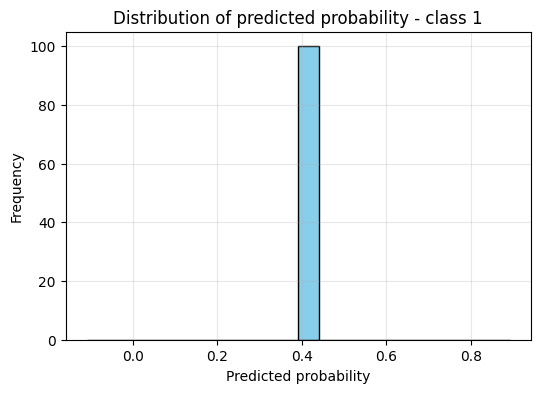

In [17]:
winning_class = int(mean_probs.argmax().item())

plt.figure(figsize=(6, 4))
plt.hist(probs[:, winning_class].numpy(), bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribution of predicted probability - class {winning_class}")
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

> **Interpretation:**  
> – Narrow peak near 1.0 → model confident  
> – Wide or multimodal distribution → model uncertain


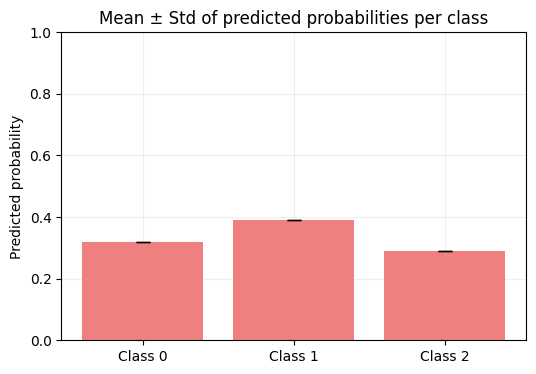

In [18]:
C = mean_probs.shape[0]
plt.figure(figsize=(6, 4))
plt.bar(np.arange(C), mean_probs.numpy(), yerr=std_probs.numpy(), capsize=5, color="lightcoral")
plt.xticks(np.arange(C), [f"Class {i}" for i in range(C)])
plt.ylabel("Predicted probability")
plt.title("Mean ± Std of predicted probabilities per class")
plt.ylim(0, 1)
plt.grid(alpha=0.2)
plt.show()

---

## Final Summary — Dropconnect Transformation Tutorial

---

This tutorial showed how the concept of `DropConnect` can be used as a powerful tool for uncertainty-aware deep learning with `probly`.
We began by understanding that `DropConnect` regularizes a model by randomly dropping individual weights, a more generalized approach than Dropout's method of dropping entire neuron activations.
We then saw how the `DropConnect` Transformation in `probly` operationalizes this for uncertainty: it replaces standard linear layers with custom, stochastic versions that remain active during inference.
By running multiple forward passes, the model reveals not only its predictions but also its confidence, which we quantified and visualized.
Through this process, we transformed `DropConnect` from a training regularizer into a practical tool for providing valuable insight into a model’s confidence and reliability.

